### Import Libs :

In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, corr, mean, max, min, log1p, expm1
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import pickle

### Create the spark Session:

In [30]:
spark = SparkSession.builder.appName("App").getOrCreate()

### Read Data:

In [31]:
def ReadDataset(file_path):
    df = spark.read.parquet(file_path)
    if df is None:
        raise Exception("Failed to read dataset")
    else :
        return df

file_path = '../data/Silver/'
df = ReadDataset(file_path)
display(df)

DataFrame[VendorID: int, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double, cbd_congestion_fee: double, Durée_minutes: int, pickup_hour: int, pickup_day_week: int, pickup_month: int]

### Shape Data:

In [32]:
print(f"({len(df.columns)},{df.count()})")

(22,2766698)


### encode 'store_and_fwd_flag' column:

In [33]:
# N => 0 | Y => 1
df = df.withColumn("store_and_fwd_flag", when(col("store_and_fwd_flag") == "N", 0).when(col("store_and_fwd_flag") == "Y", 1))
df.show()

+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-------------+-----------+---------------+------------+
|VendorID|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|Durée_minutes|pickup_hour|pickup_day_week|pickup_month|
+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-------------+-----------+---------------+------------+
|       2|              1|         2.85|         1|                 0|         230|         23

In [34]:
test = df.select('pickup_month').distinct()
test.show()

+------------+
|pickup_month|
+------------+
|           1|
|           2|
|          12|
+------------+



### Correlation matrix :

In [35]:
# 1. Get columns
df_cols = df.columns
Data = []

for i, colm1 in enumerate(df_cols):
    for j, colm2 in enumerate(df_cols):
        val = df.select(corr(colm1, colm2)).head(1)[0][0]
        Data.append((colm1, colm2, val))

corr_df = spark.createDataFrame(Data, ["Feature1", "Feature2", "corr_value"])

In [36]:
pd_corr = corr_df.toPandas()
heatmap_df = pd_corr.pivot(index="Feature1", columns="Feature2", values="corr_value")

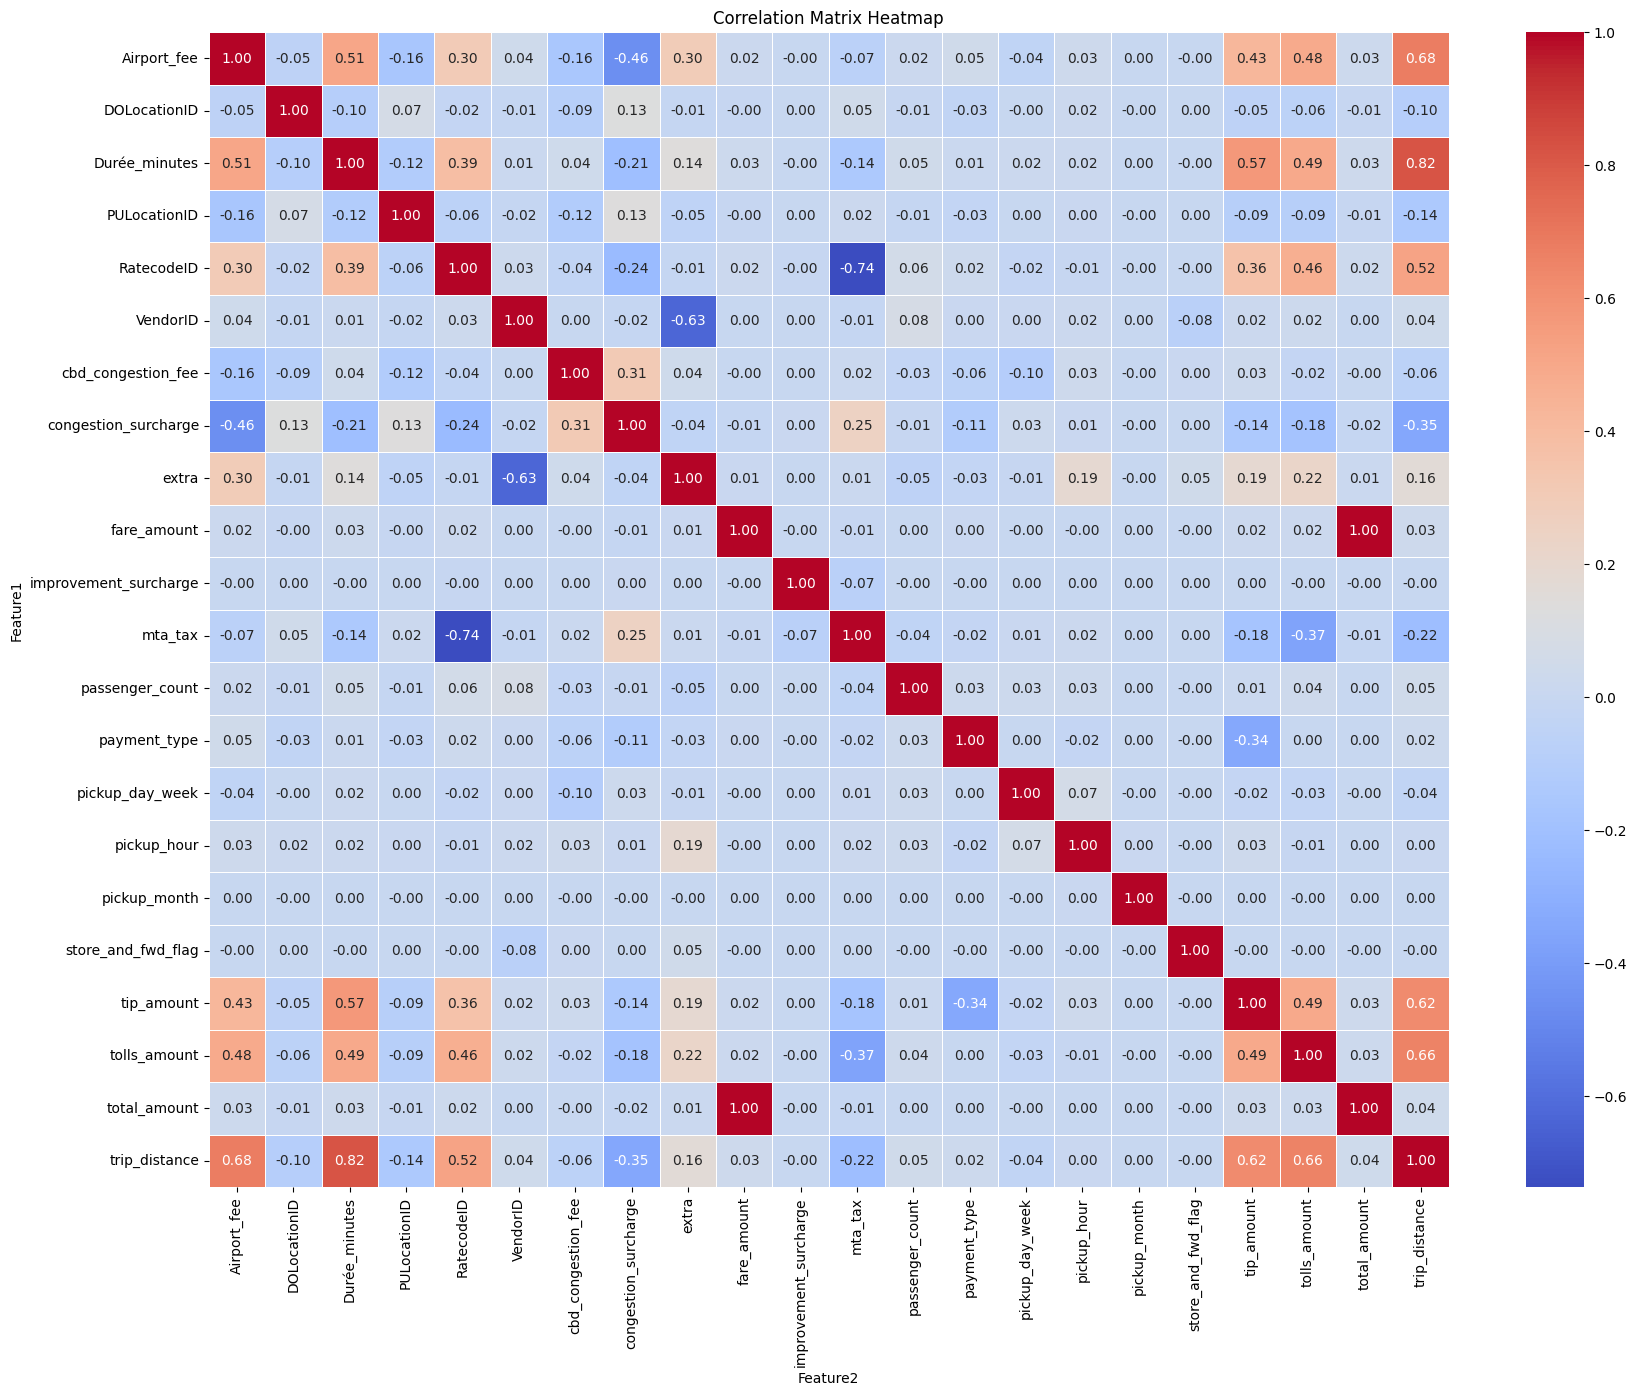

In [37]:
pd_corr = corr_df.toPandas()
heatmap_df = pd_corr.pivot(index="Feature1", columns="Feature2", values="corr_value")

plt.figure(figsize=(20, 15))
sns.heatmap(heatmap_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

### visualisation:

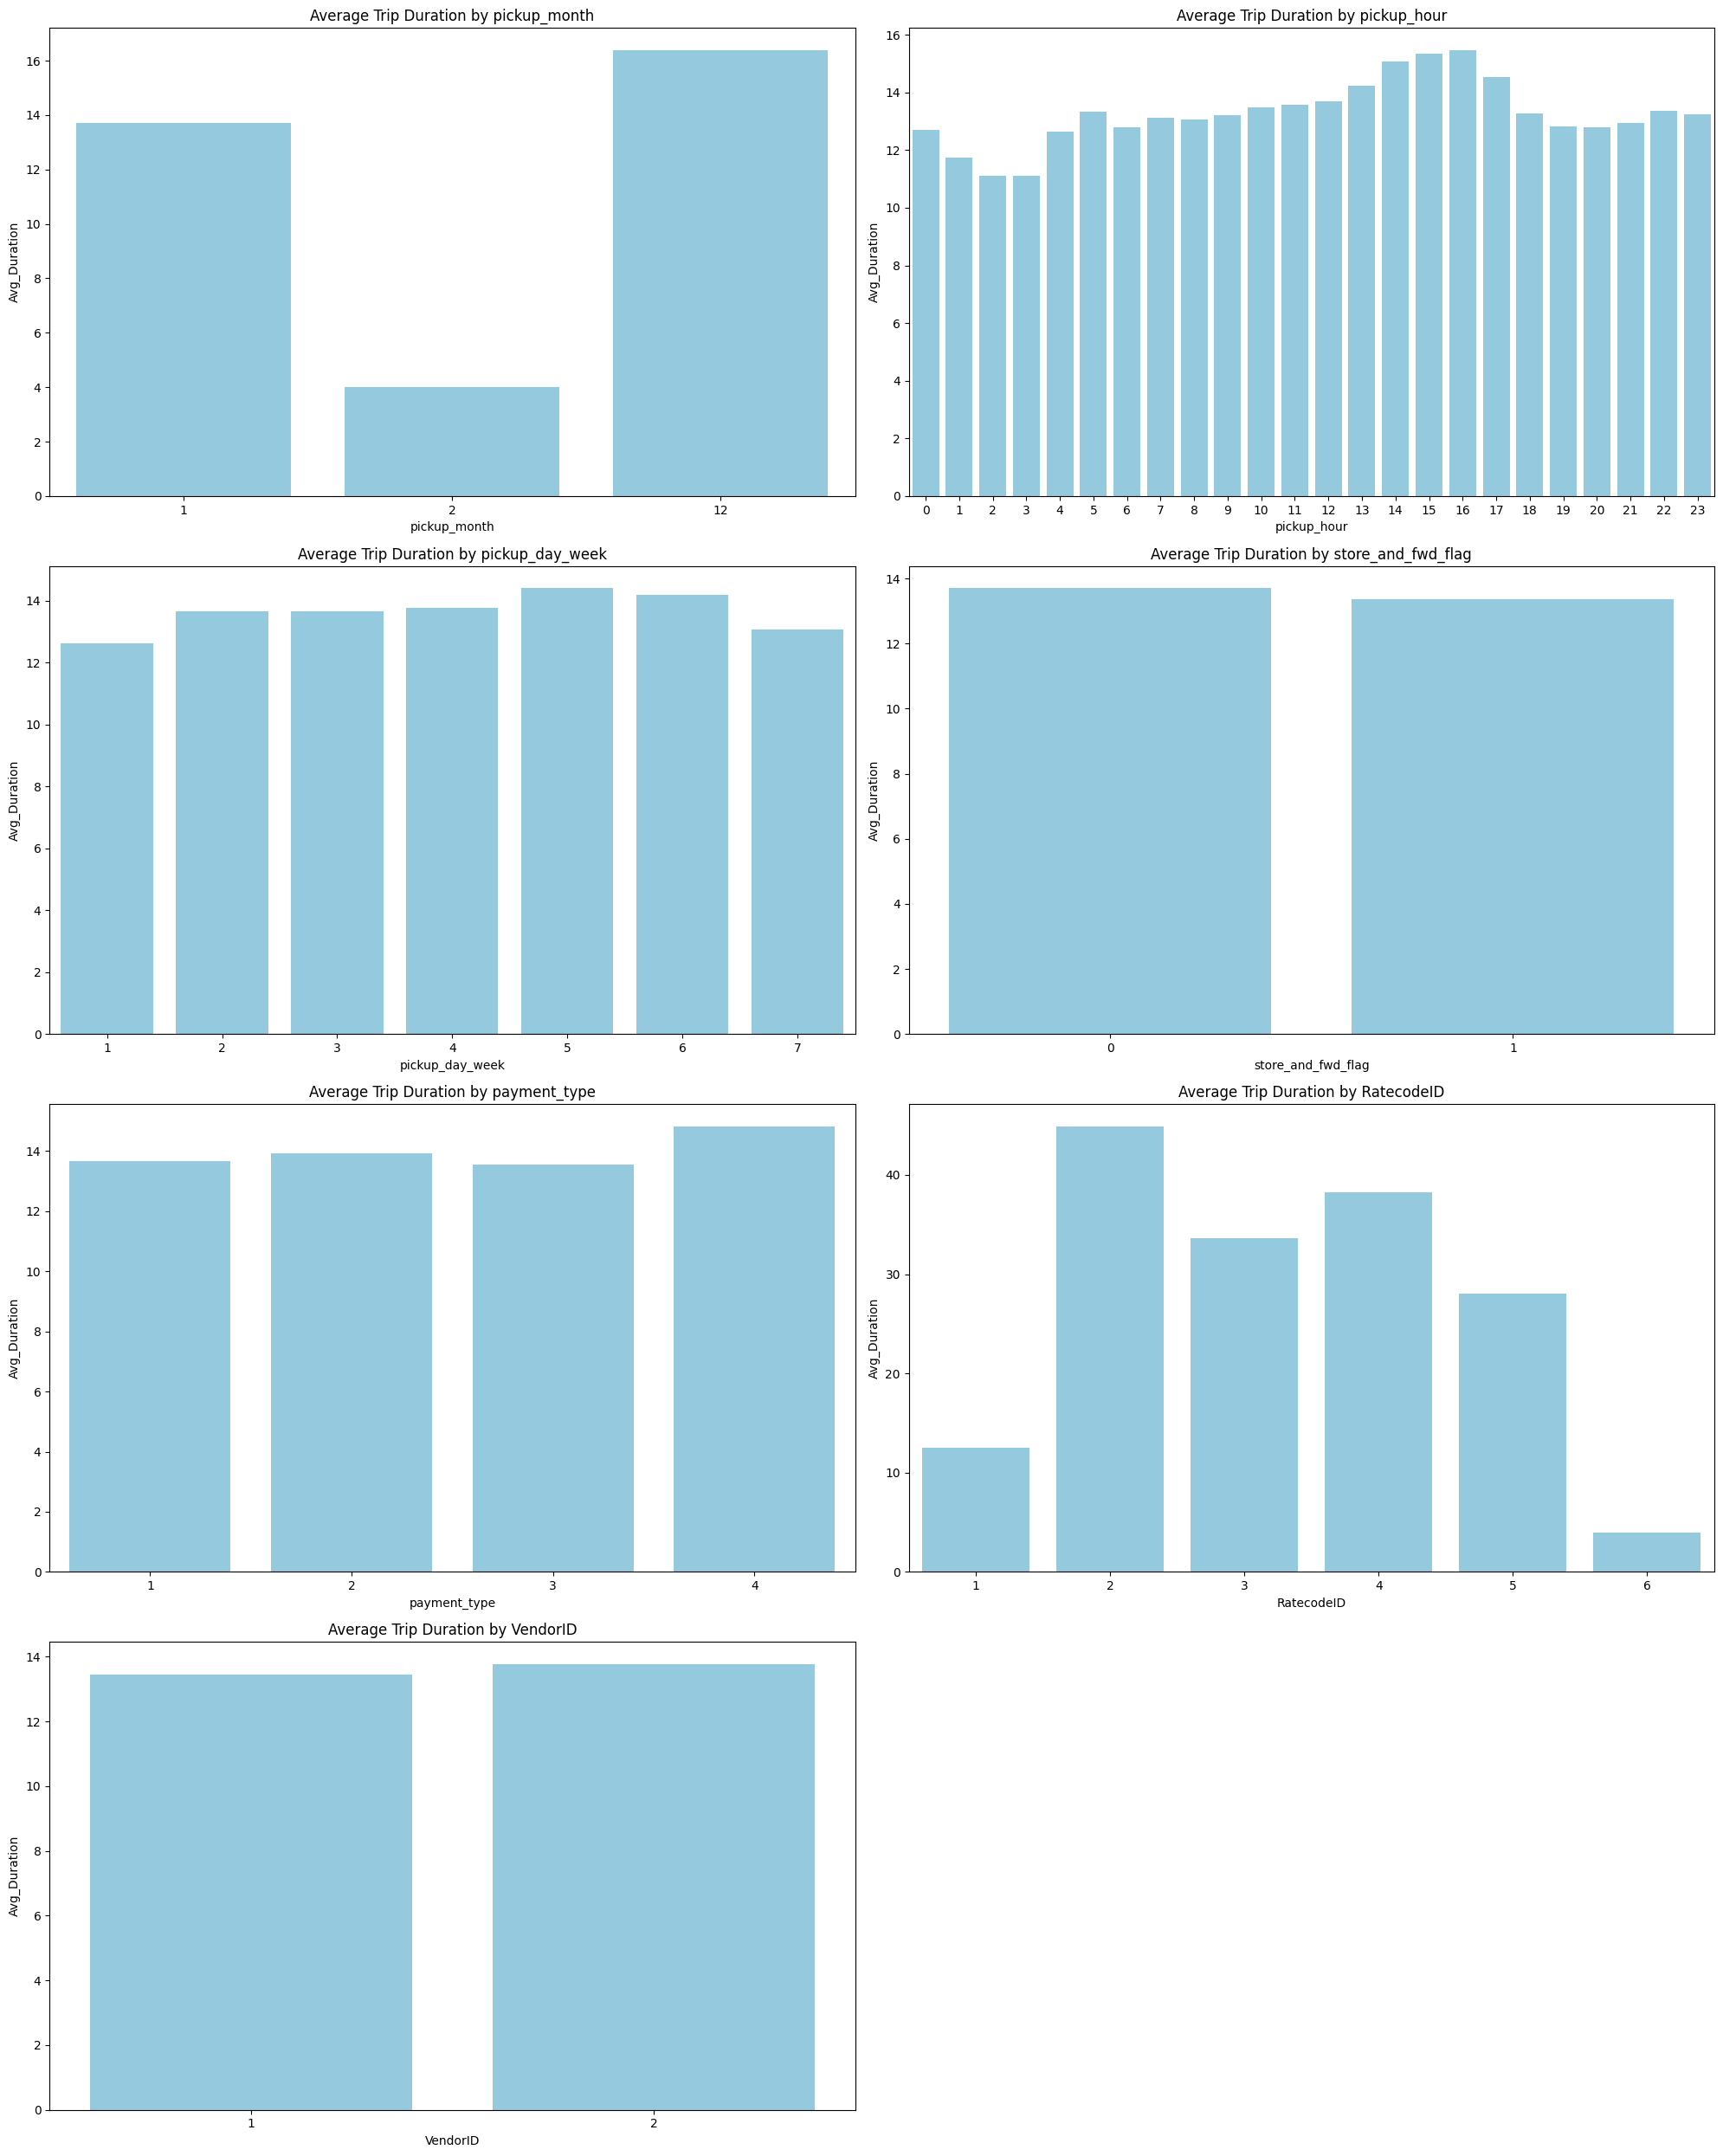

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

Cat_column = ["pickup_month","pickup_hour", "pickup_day_week", "store_and_fwd_flag",'payment_type','RatecodeID','VendorID']

plt.figure(figsize=(20, 25))

for i, colm in enumerate(Cat_column):
    hourly_stats = df.groupBy(colm).agg(mean("Durée_minutes").alias("Avg_Duration")).orderBy(colm)

    hourly_stats_pd = hourly_stats.toPandas()
    
    plt.subplot(4, 2, i+1)
    
    sns.barplot(x=colm, y='Avg_Duration', data=hourly_stats_pd, color='skyblue')
    plt.title(f'Average Trip Duration by {colm}')

plt.tight_layout()
plt.show()

In [39]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)
 |-- Durée_minutes: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_day_week: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)



### Take best Features :

In [40]:
def BestFeatures(Data):
    Best = ["trip_distance", "pickup_hour", "pickup_month", "Airport_fee", "pickup_day_week", "RateCodeID","Durée_minutes","fare_amount"]
    df_drp = df.select(Best)
    return df_drp

df_final = BestFeatures(df)
df_final.printSchema()

root
 |-- trip_distance: double (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- pickup_day_week: integer (nullable = true)
 |-- RateCodeID: long (nullable = true)
 |-- Durée_minutes: integer (nullable = true)
 |-- fare_amount: double (nullable = true)



### make data in one vector:

In [41]:
def VectorCreation(Data):
    vec_assmebler = VectorAssembler(inputCols=["trip_distance", "pickup_hour", "pickup_month", "Airport_fee", "pickup_day_week", "RateCodeID","fare_amount"], outputCol='Features')
    features_df = vec_assmebler.transform(Data)
    return features_df

features_df = VectorCreation(df_final)
features_df.printSchema()
features_df.select('Features').show(5, False)

root
 |-- trip_distance: double (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- pickup_day_week: integer (nullable = true)
 |-- RateCodeID: long (nullable = true)
 |-- Durée_minutes: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- Features: vector (nullable = true)

+--------------------------------+
|Features                        |
+--------------------------------+
|[2.85,17.0,1.0,0.0,5.0,1.0,15.6]|
|[0.48,17.0,1.0,0.0,5.0,1.0,5.8] |
|[3.16,17.0,1.0,0.0,5.0,1.0,16.3]|
|[1.37,17.0,1.0,0.0,5.0,1.0,12.8]|
|[2.06,17.0,1.0,0.0,5.0,1.0,13.5]|
+--------------------------------+
only showing top 5 rows


In [42]:
#scaler = StandardScaler(inputCol="Features", outputCol="ScaledFeatures")
#scaler_model = scaler.fit(features_df)
#scaled_df = scaler_model.transform(features_df)

#scaled_df.select("Features", "ScaledFeatures").show(5, truncate=False)

### Scale Target:

In [43]:

features_df = features_df.withColumn(
    "Durée_minutes_log",
    log1p(col("Durée_minutes"))
)

features_df.select("Durée_minutes", "Durée_minutes_log").show(5, truncate=False)

+-------------+------------------+
|Durée_minutes|Durée_minutes_log |
+-------------+------------------+
|13           |2.639057329615259 |
|3            |1.3862943611198906|
|12           |2.5649493574615367|
|12           |2.5649493574615367|
|13           |2.639057329615259 |
+-------------+------------------+
only showing top 5 rows


### Verify Scaled Target:

/tmp/ipykernel_608762/1204711554.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


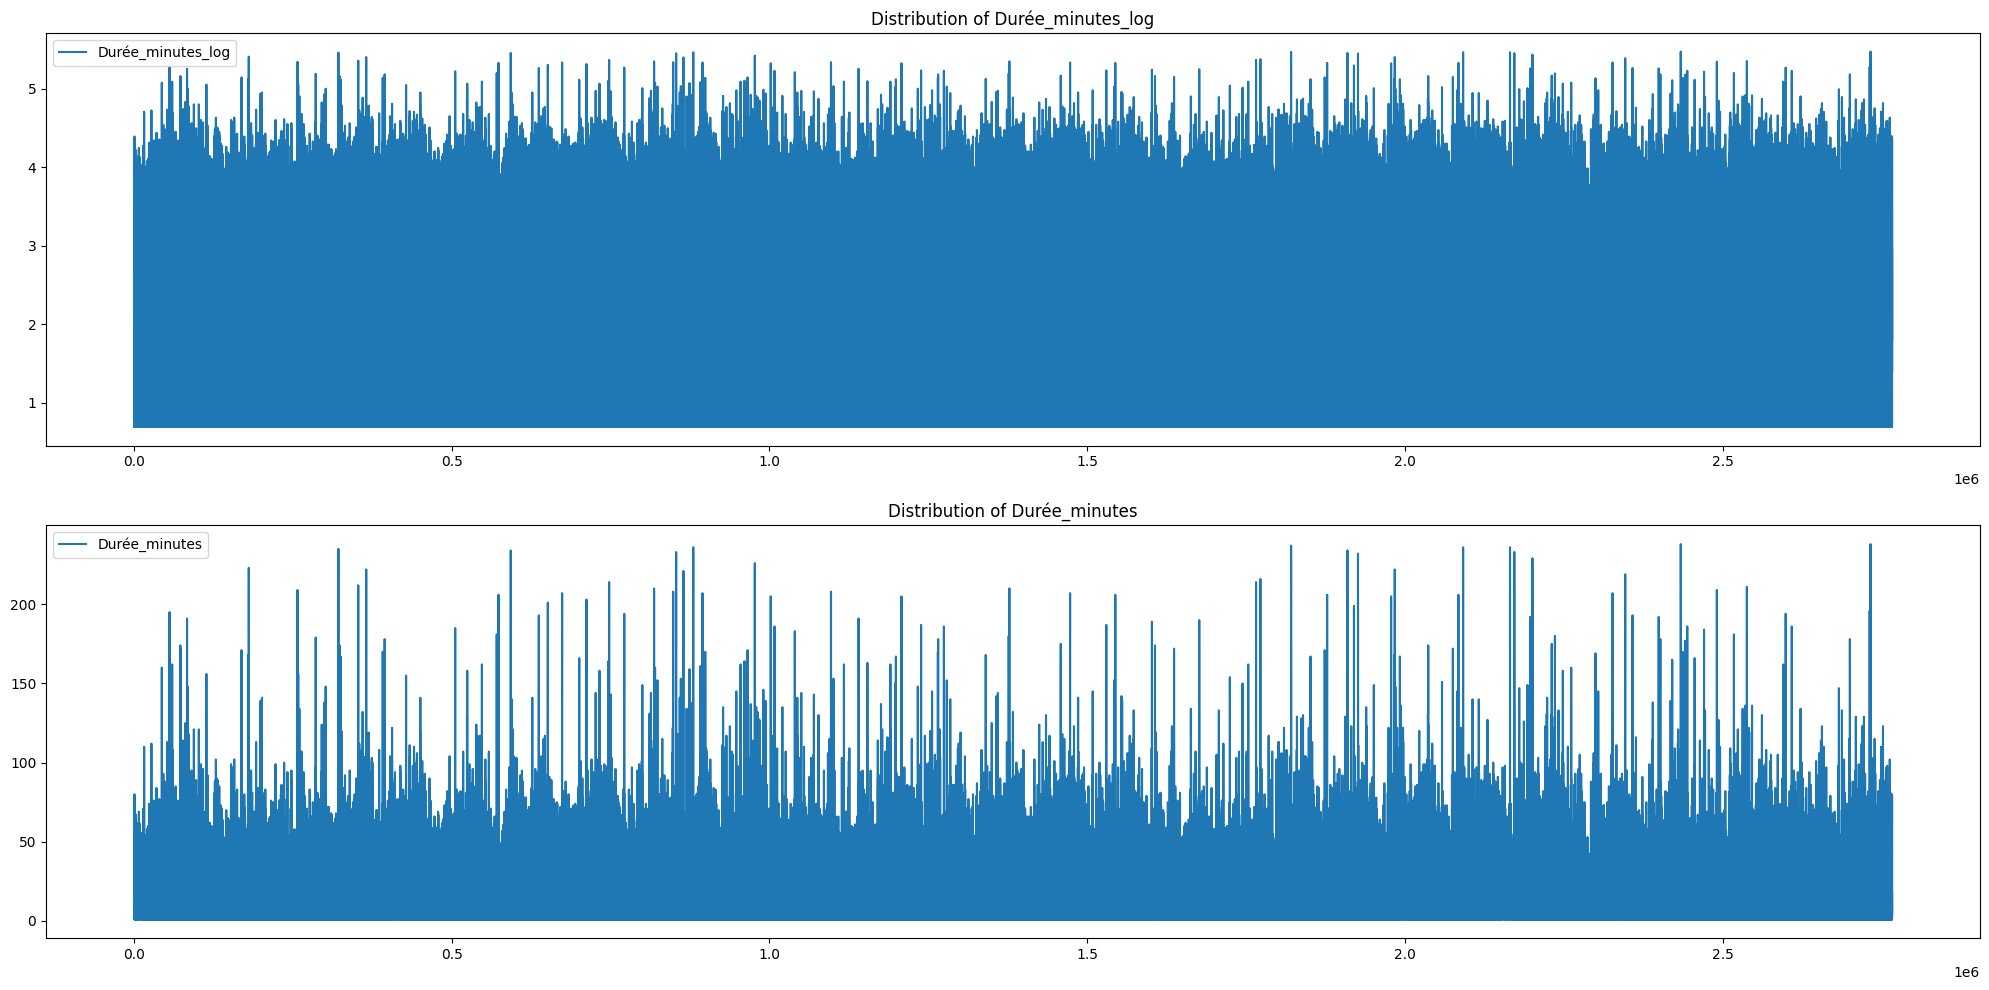

In [44]:
Targets_col = ["Durée_minutes_log", "Durée_minutes"]

plt.figure(figsize=(20, 10))
for i, target in enumerate(Targets_col):
    plt.subplot(2, 1, i+1)
    pd_target = features_df.select(target).toPandas()
    sns.lineplot(data=pd_target)
    plt.title(f'Distribution of {target}')
plt.tight_layout()
plt.show()

### Create data containing features and label:

In [45]:
def ModelDfCreator(Data):
    model_df = Data.select("Features","Durée_minutes_log","Durée_minutes")
    return model_df

model_df = ModelDfCreator(features_df)
model_df.printSchema()
model_df.show(5, False)
print(f"Shape : {(model_df.count(), len(model_df.columns))}")

root
 |-- Features: vector (nullable = true)
 |-- Durée_minutes_log: double (nullable = true)
 |-- Durée_minutes: integer (nullable = true)

+--------------------------------+------------------+-------------+
|Features                        |Durée_minutes_log |Durée_minutes|
+--------------------------------+------------------+-------------+
|[2.85,17.0,1.0,0.0,5.0,1.0,15.6]|2.639057329615259 |13           |
|[0.48,17.0,1.0,0.0,5.0,1.0,5.8] |1.3862943611198906|3            |
|[3.16,17.0,1.0,0.0,5.0,1.0,16.3]|2.5649493574615367|12           |
|[1.37,17.0,1.0,0.0,5.0,1.0,12.8]|2.5649493574615367|12           |
|[2.06,17.0,1.0,0.0,5.0,1.0,13.5]|2.639057329615259 |13           |
+--------------------------------+------------------+-------------+
only showing top 5 rows
Shape : (2766698, 3)


### Split Data - Train and Test :

In [46]:
def SplitData(Data):
    Train_df , Test_df = Data.randomSplit([0.7,0.3])
    return Train_df, Test_df

Train_df, Test_df = SplitData(model_df)
print(f"Shape Train_df : {(Train_df.count(), len(Train_df.columns))}")
print(f"Shape Test_df : {(Test_df.count(), len(Test_df.columns))}")
Test_df.describe().show()
Train_df.describe().show()

Shape Train_df : (1936147, 3)


Shape Test_df : (830551, 3)


+-------+------------------+------------------+
|summary| Durée_minutes_log|     Durée_minutes|
+-------+------------------+------------------+
|  count|            830551|            830551|
|   mean| 2.470554381918318|13.712292201201372|
| stddev|0.6578984201643164|10.851004347096776|
|    min|0.6931471805599453|                 1|
|    max| 5.476463551931511|               238|
+-------+------------------+------------------+



+-------+------------------+------------------+
|summary| Durée_minutes_log|     Durée_minutes|
+-------+------------------+------------------+
|  count|           1936147|           1936147|
|   mean| 2.469990186578345|13.698172194569937|
| stddev|  0.65748909378987| 10.80827469432711|
|    min|0.6931471805599453|                 1|
|    max| 5.476463551931511|               238|
+-------+------------------+------------------+



### Create Linear Regression Model:

In [47]:
model = LinearRegression(featuresCol="Features", labelCol="Durée_minutes")
lr_model = model.fit(Train_df)
test_result = lr_model.evaluate(Test_df)

26/01/11 23:17:55 WARN Instrumentation: [f808324a] regParam is zero, which might cause numerical instability and overfitting.


In [48]:
print(f"R2 : {test_result.r2}")
# Model predect 29% of real Predection(R2)
print(f"MAE : {test_result.meanAbsoluteError}")
# Mean Of Error (Mean) (MAE)

R2 : 0.681337296947357
MAE : 4.212235119892951


In [49]:
model2 = GBTRegressor(
    featuresCol="Features",
    labelCol="Durée_minutes_log",
    seed=42
)

lr_model2 = model2.fit(Train_df)
test_result2 = lr_model2.transform(Test_df)

In [50]:
test_result2 = test_result2.withColumn(
    "prediction_original",
    expm1(col("prediction"))
)

evaluator_r2 = RegressionEvaluator(
    labelCol="Durée_minutes_log",
    predictionCol="prediction",
    metricName="r2"
)

evaluator_mae = RegressionEvaluator(
    labelCol="Durée_minutes",
    predictionCol="prediction_original",
    metricName="mae"
)

r2 = evaluator_r2.evaluate(test_result2)
mae = evaluator_mae.evaluate(test_result2)

print(f"R2 : {r2}")
print(f"MAE : {mae}")

R2 : 0.9495988582855174
MAE : 1.6501513620952108


### Cmpare Predict With Real Vlaues :

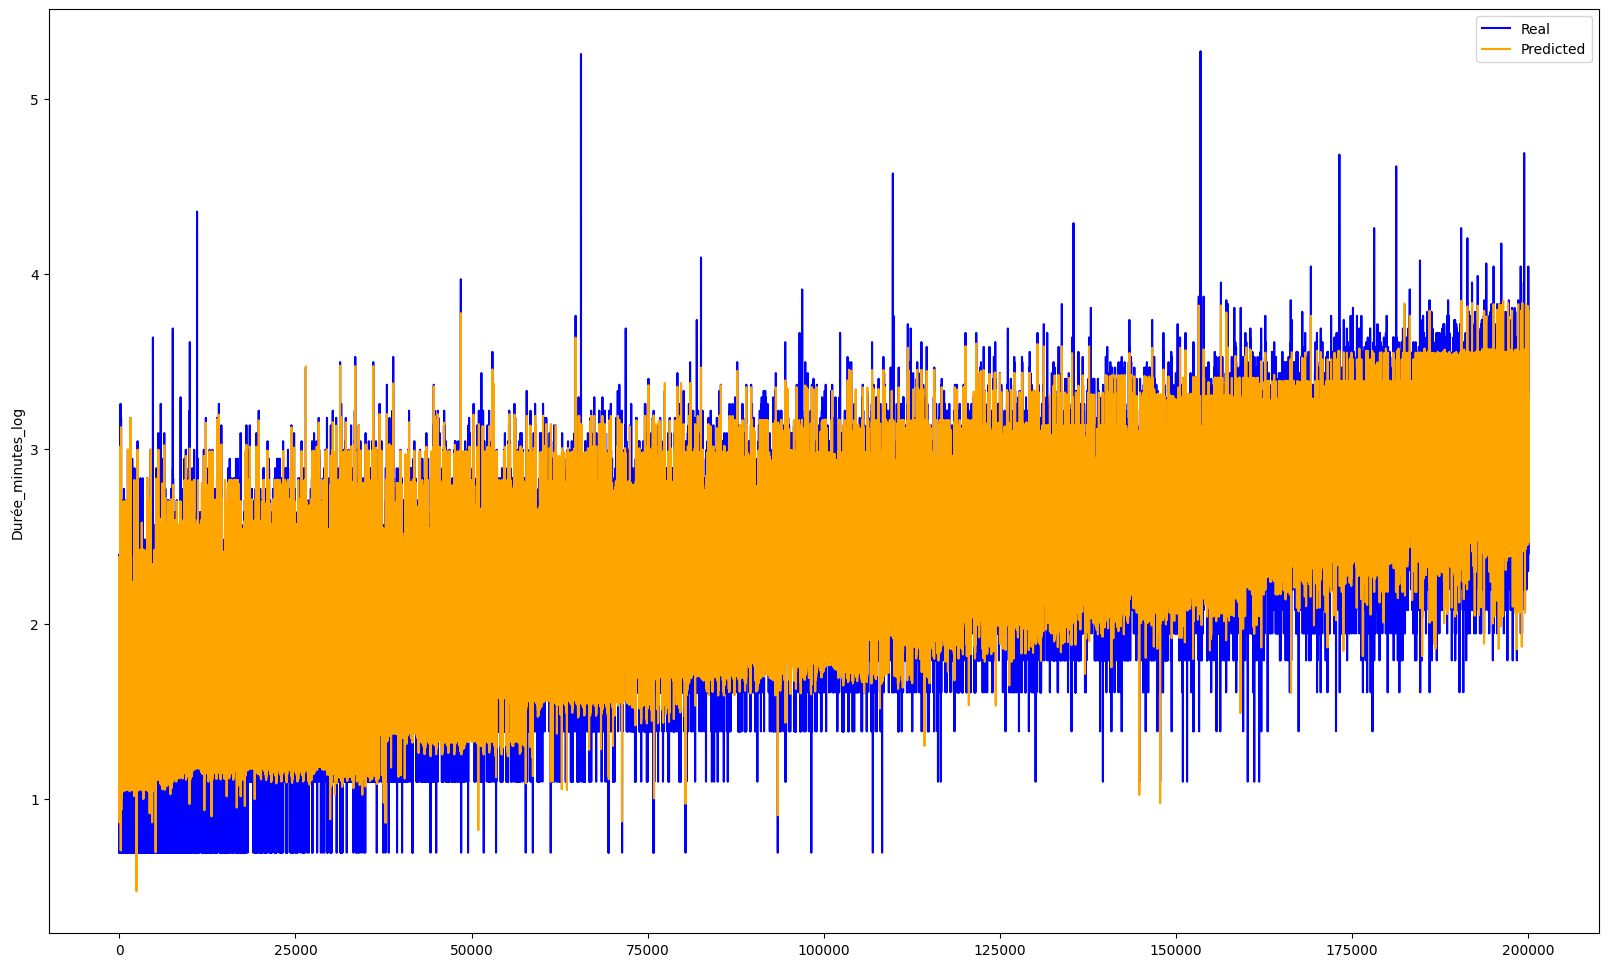

In [51]:
Prediction_values = test_result2.select("prediction").toPandas()["prediction"].head(200000)
Real_values = Test_df.select('Durée_minutes_log').toPandas()["Durée_minutes_log"].head(200000)

plt.figure(figsize=(20, 12))
sns.lineplot(data= Real_values, label="Real", color="blue")
sns.lineplot(data= Prediction_values, label="Predicted", color="orange")
plt.show()

### Save Modele:

In [52]:
model_path = "../Model/gbt_duration_minutes_v1"
lr_model2.write().overwrite().save(model_path)

### Load Model :

In [53]:
from pyspark.ml.regression import GBTRegressionModel

model_path = "../Model/gbt_duration_minutes_v1"
lr_model_loaded = GBTRegressionModel.load(model_path)

### Test Loaded Model :

In [54]:
preds = lr_model_loaded.transform(Test_df.select("Features","Durée_minutes_log"))
preds.select(expm1(col("prediction")).cast('int')).show(10)
Test_df.select("Durée_minutes").show(10)

+------------------------------+
|CAST(EXPM1(prediction) AS INT)|
+------------------------------+
|                             1|
|                             1|
|                             1|
|                             7|
|                             2|
|                             2|
|                             3|
|                             1|
|                             2|
|                             1|
+------------------------------+
only showing top 10 rows


+-------------+
|Durée_minutes|
+-------------+
|            1|
|            2|
|            1|
|            9|
|            1|
|            1|
|            1|
|            1|
|            1|
|            3|
+-------------+
only showing top 10 rows


### Test With new data:

In [55]:
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row


#fake_data = [(5.2, 14, 6, 0.0, 2, 1)]
#row = Row(Features=Vectors.dense([
#    fake_data[0][0],
#    fake_data[0][1],
#    fake_data[0][2],
#    fake_data[0][3],
#    fake_data[0][4],
#    fake_data[0][5]
#]))
#df = spark.createDataFrame([row])
#predicted_duration = lr_model_loaded.transform(df)
#predicted_duration.select("prediction").show()

In [56]:
from pyspark.ml.regression import RandomForestRegressor

model3 = RandomForestRegressor(
    featuresCol="Features",
    labelCol="Durée_minutes",
    
)

lr_model3 = model3.fit(Train_df)
test_result3 = lr_model3.transform(Test_df)
test_result3.select("prediction").show(5)

r2_r = evaluator_r2.evaluate(test_result3)
mae_ = evaluator_mae.evaluate(test_result3)

print(f"R2 : {r2_r}")
print(f"MAE : {mae_}")

26/01/11 23:19:58 WARN MemoryStore: Not enough space to cache rdd_8359_2 in memory! (computed 66.6 MiB so far)
26/01/11 23:19:58 WARN BlockManager: Persisting block rdd_8359_2 to disk instead.


+------------------+
|        prediction|
+------------------+
|3.8434893561417334|
|  3.72805340551079|
|15.409277341678607|
| 6.703084228630971|
| 4.307485762915677|
+------------------+
only showing top 5 rows


IllegalArgumentException: [FIELD_NOT_FOUND] No such struct field `prediction_original` in `Features`, `Durée_minutes_log`, `Durée_minutes`, `prediction`. SQLSTATE: 42704